In [1]:
# Verify kernel/env and install exact wheels compatible with Windows + Jupyter
import sys, os, subprocess, shutil
print("Executable:", sys.executable)
print("CONDA_PREFIX:", os.environ.get("CONDA_PREFIX"))

# Install compatible imaging + utils (NumPy 1.26, OpenCV 4.9, Albumentations 1.3.1)
%pip install --quiet numpy==1.26.4 opencv-python==4.9.0.80 albumentations==1.3.1 torchmetrics scikit-learn tqdm seaborn

# Ensure torchvision present (match your existing torch build; no-deps to avoid replacing torch)
%pip install --quiet --no-deps torchvision

# Sanity: GPU and versions
import torch, pkgutil
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
print("Has pytorch-cuda?:", any(m.name=="pytorch_cuda" for m in pkgutil.iter_modules()))
if shutil.which("nvidia-smi"):
    print(subprocess.check_output(["nvidia-smi","-L"], text=True))


Executable: C:\Users\Sohum\anaconda3\envs\ai-agri\python.exe
CONDA_PREFIX: C:\Users\Sohum\anaconda3
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Torch: 2.5.1+cu121 CUDA available: True
Has pytorch-cuda?: False
GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU (UUID: GPU-2232d472-e75c-216d-8585-0277066d5bc8)



In [2]:
import os, glob, shutil, random, pathlib
random.seed(42)

SOURCE_DIR = r"C:\Datasets\sugarcane_dib_2024\Sugarcane_Leaf_Dataset"   # class folders with images
TARGET_DIR = r"C:\Datasets\sugarcane_dib_2024\Sugarcane_Leaf_Splits"    # will be created

def list_images(root):
    IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}
    out = []
    for dp, dn, fn in os.walk(root):
        for f in fn:
            if pathlib.Path(f).suffix.lower() in IMG_EXTS:
                out.append(os.path.join(dp, f))
    return out

# Clean previous split to avoid leftovers
for sub in ["train","val","test"]:
    p = os.path.join(TARGET_DIR, sub)
    if os.path.isdir(p): shutil.rmtree(p)

classes = sorted([d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))])
print("Detected classes:", classes)

splits = {"train":0.8, "val":0.1, "test":0.1}
for split in splits:
    for c in classes:
        os.makedirs(os.path.join(TARGET_DIR, split, c), exist_ok=True)

copied = {"train":0,"val":0,"test":0}
for c in classes:
    imgs = list_images(os.path.join(SOURCE_DIR, c))
    random.shuffle(imgs)
    n=len(imgs); nt=int(n*splits["train"]); nv=int(n*splits["val"])
    parts=[(imgs[:nt],"train"),(imgs[nt:nt+nv],"val"),(imgs[nt+nv:],"test")]
    for paths, split in parts:
        dst = os.path.join(TARGET_DIR, split, c)
        for s in paths:
            try:
                shutil.copy2(s, os.path.join(dst, os.path.basename(s))); copied[split]+=1
            except Exception as e:
                print("SKIP:", s, "->", e)
print("Split complete:", copied)


Detected classes: ['Banded Chlorosis', 'Brown Spot', 'BrownRust', 'Dried Leaves', 'Grassy shoot', 'Healthy Leaves', 'Pokkah Boeng', 'Sett Rot', 'Viral Disease', 'Yellow Leaf', 'smut']
Split complete: {'train': 5393, 'val': 671, 'test': 684}


In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets
from torch.utils.data import DataLoader
import cv2, torch

IMG_SIZE = 224

train_tf = A.Compose([
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.7, 1.0), ratio=(0.8, 1.2)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.6),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.5),
    A.HueSaturationValue(10,10,10, p=0.3),
    A.GaussianBlur(blur_limit=(3,3), p=0.2),
    A.CoarseDropout(max_holes=2, max_height=IMG_SIZE//10, max_width=IMG_SIZE//10, p=0.25),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])
eval_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class AlbumentationsImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root); self.alb_tf = transform
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = cv2.imread(path)
        if img is None: raise FileNotFoundError(path)
        img = img[:, :, ::-1]
        if self.alb_tf is not None: img = self.alb_tf(image=img)['image']
        return img, target

TRAIN_DIR = os.path.join(TARGET_DIR, "train")
VAL_DIR   = os.path.join(TARGET_DIR, "val")
TEST_DIR  = os.path.join(TARGET_DIR, "test")

train_ds = AlbumentationsImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = AlbumentationsImageFolder(VAL_DIR,   transform=eval_tf)
test_ds  = AlbumentationsImageFolder(TEST_DIR,  transform=eval_tf)

classes = train_ds.classes; num_classes = len(classes)
print("Classes:", num_classes, classes)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", DEVICE)
if DEVICE=='cuda': torch.backends.cudnn.benchmark=True

# Windows/Jupyter: start with workers=0
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0, pin_memory=(DEVICE=='cuda'))
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0, pin_memory=(DEVICE=='cuda'))
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0, pin_memory=(DEVICE=='cuda'))

xb, yb = next(iter(train_dl))
print("Warm batch:", xb.shape, yb.shape)


Classes: 11 ['Banded Chlorosis', 'Brown Spot', 'BrownRust', 'Dried Leaves', 'Grassy shoot', 'Healthy Leaves', 'Pokkah Boeng', 'Sett Rot', 'Viral Disease', 'Yellow Leaf', 'smut']
Device: cuda
Warm batch: torch.Size([32, 3, 224, 224]) torch.Size([32])


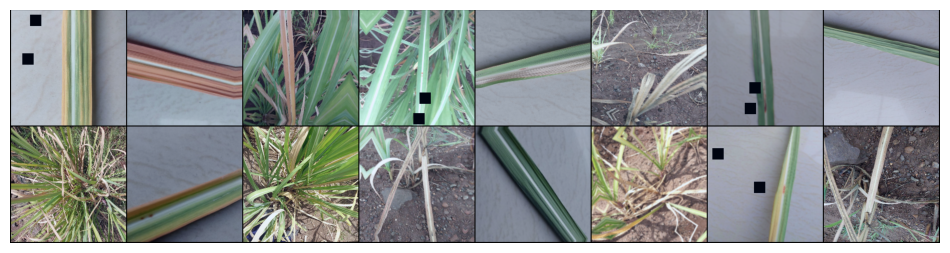

['Yellow Leaf', 'Dried Leaves', 'Yellow Leaf', 'Brown Spot', 'Brown Spot', 'Sett Rot', 'Brown Spot', 'Viral Disease', 'Grassy shoot', 'Brown Spot', 'Yellow Leaf', 'Sett Rot', 'Viral Disease', 'smut', 'Brown Spot', 'Sett Rot']


In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt, numpy as np

grid = make_grid(xb[:16], nrow=8, normalize=True)
plt.figure(figsize=(12,4)); plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.axis('off'); plt.show()
print([classes[i] for i in yb[:16].tolist()])


In [5]:
from torch import nn
import torch

class ConvBNReLU(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, k, s, p, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = ConvBNReLU(3, 32, s=2)
        self.layer1 = nn.Sequential(ConvBNReLU(32,64),  ConvBNReLU(64,64),  nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(ConvBNReLU(64,128), ConvBNReLU(128,128), nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(ConvBNReLU(128,256),ConvBNReLU(256,256), nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(ConvBNReLU(256,512), nn.AdaptiveAvgPool2d(1))
        self.head   = nn.Sequential(nn.Flatten(), nn.Dropout(0.35), nn.Linear(512, num_classes))
    def forward(self, x):
        x = self.stem(x); x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        return self.head(x)

model = BasicCNN(num_classes).to(DEVICE)
print("Params (M):", round(sum(p.numel() for p in model.parameters())/1e6, 3))


Params (M): 2.35


In [6]:
import torchmetrics
from torch.optim.lr_scheduler import CosineAnnealingLR

EPOCHS = 30; LR = 3e-4; WEIGHT_DECAY = 1e-4
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

acc_metric  = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='macro').to(DEVICE)
f1_metric   = torchmetrics.classification.MulticlassF1Score(num_classes=num_classes, average='macro').to(DEVICE)
prec_metric = torchmetrics.classification.MulticlassPrecision(num_classes=num_classes, average='macro').to(DEVICE)
rec_metric  = torchmetrics.classification.MulticlassRecall(num_classes=num_classes, average='macro').to(DEVICE)


In [7]:
from copy import deepcopy
from tqdm import tqdm
import torch

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=='cuda'))
best_wts, best_val_f1 = None, -1
patience, wait = 8, 0

def run_epoch(dl, train=False):
    model.train(train)
    total = 0.0
    acc_metric.reset(); f1_metric.reset(); prec_metric.reset(); rec_metric.reset()
    for xb, yb in tqdm(dl, total=len(dl)):
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=='cuda')):
            logits = model(xb); loss = criterion(logits, yb)
        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer); scaler.update()
        total += loss.item()*xb.size(0)
        preds = logits.argmax(1)
        acc_metric.update(preds, yb); f1_metric.update(preds, yb)
        prec_metric.update(preds, yb); rec_metric.update(preds, yb)
    n = len(dl.dataset)
    return {'loss': total/n, 'acc': acc_metric.compute().item(),
            'f1': f1_metric.compute().item(), 'prec': prec_metric.compute().item(),
            'rec': rec_metric.compute().item()}

history = {'train':[], 'val':[]}
for epoch in range(1, EPOCHS+1):
    tr = run_epoch(train_dl, train=True)
    va = run_epoch(val_dl,   train=False)
    scheduler.step()
    history['train'].append(tr); history['val'].append(va)
    print(f"Epoch {epoch:02d} | Train F1 {tr['f1']:.3f} | Val F1 {va['f1']:.3f} | Val Acc {va['acc']:.3f}")
    if va['f1'] > best_val_f1:
        best_val_f1, best_wts, wait = va['f1'], deepcopy(model.state_dict()), 0
    else:
        wait += 1
        if wait >= patience: print("Early stopping."); break
if best_wts: model.load_state_dict(best_wts)


C:\Users\Sohum\AppData\Local\Temp\ipykernel_21572\678225670.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=='cuda'))
C:\Users\Sohum\AppData\Local\Temp\ipykernel_21572\678225670.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=='cuda')):
100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


Epoch 01 | Train F1 0.353 | Val F1 0.387 | Val Acc 0.403


100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


Epoch 02 | Train F1 0.507 | Val F1 0.439 | Val Acc 0.457


100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


Epoch 03 | Train F1 0.535 | Val F1 0.512 | Val Acc 0.499


100%|██████████| 21/21 [00:07<00:00,  2.85it/s]


Epoch 04 | Train F1 0.595 | Val F1 0.626 | Val Acc 0.636


100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


Epoch 05 | Train F1 0.644 | Val F1 0.607 | Val Acc 0.604


100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


Epoch 06 | Train F1 0.688 | Val F1 0.729 | Val Acc 0.733


100%|██████████| 21/21 [00:07<00:00,  2.89it/s]


Epoch 07 | Train F1 0.706 | Val F1 0.776 | Val Acc 0.768


100%|██████████| 21/21 [00:07<00:00,  2.82it/s]


Epoch 08 | Train F1 0.729 | Val F1 0.701 | Val Acc 0.705


100%|██████████| 21/21 [00:07<00:00,  2.87it/s]


Epoch 09 | Train F1 0.761 | Val F1 0.748 | Val Acc 0.733


100%|██████████| 21/21 [00:07<00:00,  2.88it/s]


Epoch 10 | Train F1 0.786 | Val F1 0.741 | Val Acc 0.764


100%|██████████| 21/21 [00:07<00:00,  2.89it/s]


Epoch 11 | Train F1 0.806 | Val F1 0.798 | Val Acc 0.783


100%|██████████| 21/21 [00:07<00:00,  2.89it/s]


Epoch 12 | Train F1 0.813 | Val F1 0.792 | Val Acc 0.805


100%|██████████| 21/21 [00:07<00:00,  2.80it/s]


Epoch 13 | Train F1 0.833 | Val F1 0.836 | Val Acc 0.845


100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


Epoch 14 | Train F1 0.840 | Val F1 0.830 | Val Acc 0.813


100%|██████████| 21/21 [00:07<00:00,  2.87it/s]


Epoch 15 | Train F1 0.858 | Val F1 0.860 | Val Acc 0.870


100%|██████████| 21/21 [00:07<00:00,  2.89it/s]


Epoch 16 | Train F1 0.865 | Val F1 0.891 | Val Acc 0.894


100%|██████████| 21/21 [00:07<00:00,  2.82it/s]


Epoch 17 | Train F1 0.874 | Val F1 0.886 | Val Acc 0.888


100%|██████████| 21/21 [00:07<00:00,  2.90it/s]


Epoch 18 | Train F1 0.883 | Val F1 0.887 | Val Acc 0.891


100%|██████████| 21/21 [00:07<00:00,  2.93it/s]


Epoch 19 | Train F1 0.891 | Val F1 0.908 | Val Acc 0.911


100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


Epoch 20 | Train F1 0.891 | Val F1 0.871 | Val Acc 0.877


100%|██████████| 21/21 [00:07<00:00,  2.83it/s]


Epoch 21 | Train F1 0.895 | Val F1 0.892 | Val Acc 0.894


100%|██████████| 21/21 [00:07<00:00,  2.83it/s]


Epoch 22 | Train F1 0.888 | Val F1 0.909 | Val Acc 0.913


100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


Epoch 23 | Train F1 0.898 | Val F1 0.903 | Val Acc 0.909


100%|██████████| 21/21 [00:07<00:00,  2.91it/s]


Epoch 24 | Train F1 0.907 | Val F1 0.892 | Val Acc 0.894


100%|██████████| 21/21 [00:07<00:00,  2.90it/s]


Epoch 25 | Train F1 0.896 | Val F1 0.905 | Val Acc 0.909


100%|██████████| 21/21 [00:07<00:00,  2.95it/s]


Epoch 26 | Train F1 0.897 | Val F1 0.899 | Val Acc 0.902


100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


Epoch 27 | Train F1 0.908 | Val F1 0.897 | Val Acc 0.901


100%|██████████| 21/21 [00:07<00:00,  2.88it/s]


Epoch 28 | Train F1 0.906 | Val F1 0.891 | Val Acc 0.893


100%|██████████| 21/21 [00:07<00:00,  2.91it/s]


Epoch 29 | Train F1 0.909 | Val F1 0.898 | Val Acc 0.900


100%|██████████| 21/21 [00:07<00:00,  2.88it/s]

Epoch 30 | Train F1 0.907 | Val F1 0.898 | Val Acc 0.902
Early stopping.


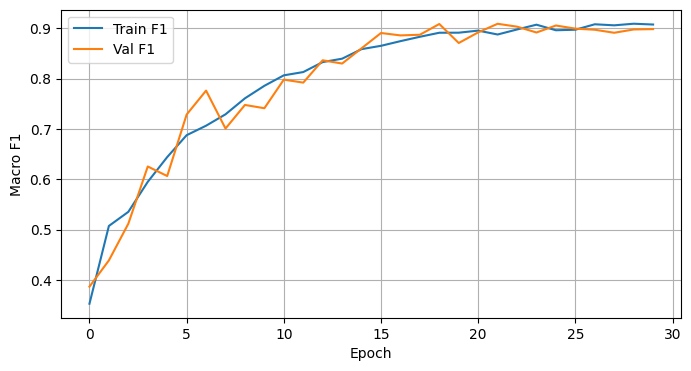

TypeError: ConfusionMatrixDisplay.plot() got an unexpected keyword argument 'figsize'

In [8]:
import matplotlib.pyplot as plt, numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

plt.figure(figsize=(8,4))
plt.plot([e['f1'] for e in history['train']], label='Train F1')
plt.plot([e['f1'] for e in history['val']],   label='Val F1')
plt.grid(True); plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Macro F1'); plt.show()

model.eval(); y_true, y_pred = [], []
with torch.inference_mode():
    for xb, yb in val_dl:
        y_pred.extend(model(xb.to(DEVICE)).argmax(1).cpu().numpy())
        y_true.extend(yb.numpy())
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Blues', xticks_rotation=45, figsize=(9,9)); plt.show()

y_true, y_pred = [], []
with torch.inference_mode():
    for xb, yb in test_dl:
        y_pred.extend(model(xb.to(DEVICE)).argmax(1).cpu().numpy())
        y_true.extend(yb.numpy())
print(classification_report(y_true, y_pred, target_names=classes, digits=4))


In [10]:
%pip install onnx onnxruntime


   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   -------- ------------------------------- 3.4/16.5 MB 20.2 MB/s eta 0:00:01
   --------------- ------------------------ 6.3/16.5 MB 15.5 MB/s eta 0:00:01
   --------------------- ------------------ 8.9/16.5 MB 14.6 MB/s eta 0:00:01
   ---------------------------- ----------- 11.5/16.5 MB 14.1 MB/s eta 0:00:01
   ---------------------------------- ----- 14.2/16.5 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 16.5/16.5 MB 13.5 MB/s  0:00:01
   ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
   --------- ------------------------------ 3.1/12.7 MB 15.3 MB/s eta 0:00:01
   ------------------- -------------------- 6.0/12.7 MB 13.7 MB/s eta 0:00:01
   --------------------------- ------------ 8.7/12.7 MB 13.4 MB/s eta 0:00:01
   ----------------------------------- ---- 11.3/12.7 MB 13.3 MB/s eta 0:00:01
   ---------------------------------------- 12.7/12.7 MB 13.0 MB/s  0:00:00

  

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [11]:
import os, torch
export_dir = r"C:\Datasets\sugarcane_dib_2024\cnn_exports"
os.makedirs(export_dir, exist_ok=True)

with open(os.path.join(export_dir, "labels.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(classes))

example = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
traced = torch.jit.trace(model, example)
torch.jit.save(traced, os.path.join(export_dir, "cnn_sugarcane_ts.pt"))

torch.onnx.export(
    model, example, os.path.join(export_dir, "cnn_sugarcane.onnx"),
    input_names=['input'], output_names=['logits'],
    opset_version=17, do_constant_folding=True,
    dynamic_axes={'input':{0:'batch'}, 'logits':{0:'batch'}}
)
print("Exports saved to:", export_dir)


Exports saved to: C:\Datasets\sugarcane_dib_2024\cnn_exports


In [12]:
import numpy as np, cv2

def load_image(path, size=IMG_SIZE):
    img = cv2.imread(path); assert img is not None, path
    img = img[:, :, ::-1]
    return eval_tf(image=img)['image'].unsqueeze(0)

def predict_image(path):
    model.eval()
    x = load_image(path).to(DEVICE)
    with torch.inference_mode():
        prob = torch.softmax(model(x), dim=1).squeeze().cpu().numpy()
    i = int(np.argmax(prob))
    return classes[i], float(prob[i])

# Example:
# predict_image(r"C:\Datasets\sugarcane_dib_2024\Sugarcane_Leaf_Splits\test\Yellow Leaf\sample.jpg")


Test Accuracy: 0.9167
Test F1 (macro): 0.8813
Test F1 (micro): 0.9167

                  precision    recall  f1-score   support

Banded Chlorosis     0.8627    0.9167    0.8889        48
      Brown Spot     0.9940    0.9595    0.9765       173
       BrownRust     0.9333    0.8750    0.9032        32
    Dried Leaves     0.8462    0.9429    0.8919        35
    Grassy shoot     1.0000    0.9722    0.9859        36
  Healthy Leaves     1.0000    0.9535    0.9762        43
    Pokkah Boeng     0.6970    0.7419    0.7188        31
        Sett Rot     1.0000    1.0000    1.0000        66
   Viral Disease     0.8421    0.9552    0.8951        67
     Yellow Leaf     0.9407    0.9250    0.9328       120
            smut     0.5714    0.4848    0.5246        33

        accuracy                         0.9167       684
       macro avg     0.8807    0.8843    0.8813       684
    weighted avg     0.9176    0.9167    0.9162       684



<Figure size 900x900 with 0 Axes>

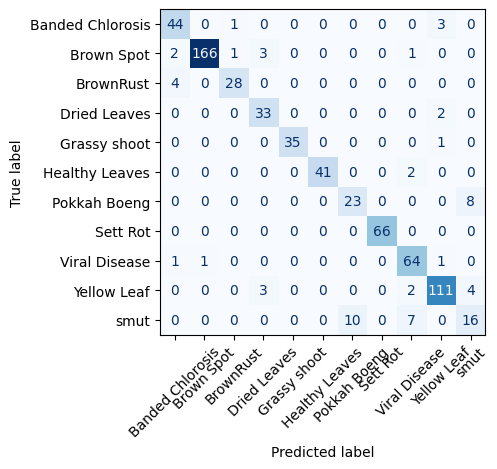

In [13]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()
y_true, y_pred = [], []
with torch.inference_mode():
    for xb, yb in test_dl:
        logits = model(xb.to(DEVICE))
        y_pred.extend(logits.argmax(1).cpu().numpy())
        y_true.extend(yb.numpy())

y_true = np.array(y_true); y_pred = np.array(y_pred)
acc  = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 (macro): {f1_macro:.4f}")
print(f"Test F1 (micro): {f1_micro:.4f}")
print()
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
plt.figure(figsize=(9,9))
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.tight_layout(); plt.show()


In [14]:
import random, glob, os, numpy as np, cv2, torch

def predict_image(path):
    img = cv2.imread(path)[:, :, ::-1]
    x = eval_tf(image=img)['image'].unsqueeze(0).to(DEVICE)
    with torch.inference_mode():
        prob = torch.softmax(model(x), dim=1).squeeze().cpu().numpy()
    i = int(np.argmax(prob))
    return classes[i], float(prob[i])

# pick 5 random test images across classes
samples = []
for c in classes:
    paths = glob.glob(os.path.join(TEST_DIR, c, "*"))
    if paths: samples.append(random.choice(paths))
random.shuffle(samples)
samples = samples[:5]

for p in samples:
    pred, conf = predict_image(p)
    print(os.path.basename(p), "->", pred, f"({conf:.3f})")


Pokkah Boeng185.jpg -> Pokkah Boeng (0.489)
image075.jpg -> Grassy shoot (0.989)
image331.jpg -> Healthy Leaves (0.918)
image230.jpg -> Banded Chlorosis (0.979)
Viral Disease516.jpg -> Viral Disease (0.548)
